
# Modeling



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

from statsmodels.tsa.stattools import adfuller

In [2]:
df = pd.read_csv('data/masterdf.csv')
col_to_delete = ['Out Duration', 'Return Duration', 'timestamp', 'Out Time', 
                 'Return Time', 'sort', 'Out Stop Cities', 'Return Stop Cities',
                'Out Airline', 'Return Airline']
df = df.drop(col_to_delete, axis = 1)
df.head()

,Out Cities,Out Stops,Return Cities,Return Stops,Price,departure_date,total_duration,dep_time,ret_time,dep_airline,ret_airline,total_stops,target
0,EWR‐SIN,2,SIN‐EWR,2,951,2022-04-10,3245,8:00,1:10,Korean Air,Korean Air,4,0
1,EWR‐SIN,2,SIN‐EWR,2,979,2022-04-10,3185,9:00,1:10,Korean Air,Korean Air,4,0
2,EWR‐SIN,1,SIN‐EWR,1,994,2022-04-10,2860,11:25,6:10,ANA,ANA,2,1
3,EWR‐SIN,2,SIN‐EWR,1,994,2022-04-10,3155,6:30,6:10,ANA,ANA,3,0
4,EWR‐SIN,1,SIN‐EWR,2,998,2022-04-10,3627,11:25,10:10,ANA,ANA,3,0


In [3]:
# For testing stationarity
def dicky_fuller_test(data):
    alpha = 0.05
    is_stationary = adfuller(data)[1] < alpha
    if is_stationary == True:
        print(f'The data is stationary with a fuller score of {round(adfuller(data)[1],3)}')
    else:
        print(f'The data is not stationary with a fuller score of {round(adfuller(data)[1],3)}')
    return

In [4]:
time_df = df.set_index(pd.to_datetime(df['departure_date']), drop=True)

time_df = time_df['Price']

The data is stationary with a fuller score of 0.0


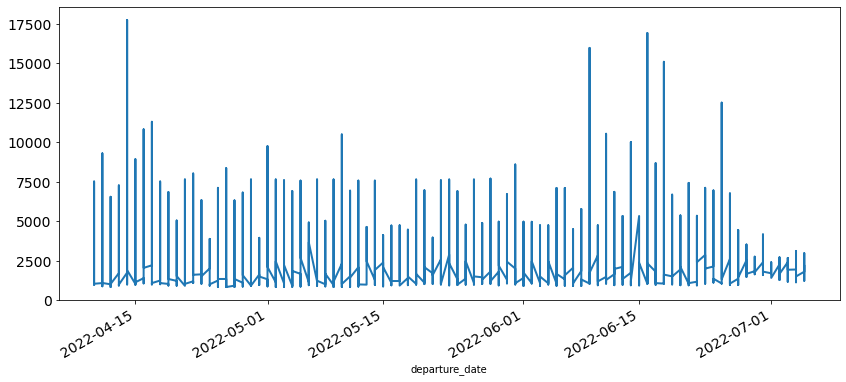

In [5]:
time_df.plot(figsize=(14,6), linewidth=2, fontsize=14);
dicky_fuller_test(time_df)

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [7]:
X = df.drop('target', axis=1)
y = df['target']

In [8]:
numeric_features = X.select_dtypes('int64')
numeric_features
ss = StandardScaler()
num_df = pd.DataFrame(ss.fit_transform(numeric_features),
                     columns = numeric_features.columns,
                     index = numeric_features.index)
num_df.head()

,Out Stops,Return Stops,Price,total_duration,total_stops
0,1.488991,1.560860,-0.766888,0.935398,1.878633
1,1.488991,1.560860,-0.737634,0.830532,1.878633
2,0.073627,0.098238,-0.721962,0.262508,0.105656
3,1.488991,0.098238,-0.721962,0.778099,0.992145
4,0.073627,1.560860,-0.717782,1.603045,0.992145


In [9]:
from sklearn.pipeline import Pipeline

In [10]:
numeric_features = X.select_dtypes(exclude="object").columns
numeric_transformer = Pipeline(
    steps=[("scaler", StandardScaler())]
)

categorical_features = X.select_dtypes(include="object").columns
categorical_transformer = OneHotEncoder()

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

In [11]:
# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
baseline = Pipeline(steps=[
    ("preprocessor", preprocessor), 
    ("classifier", LogisticRegression(random_state=32))
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=32)

baseline.fit(X_train, y_train)
print("model score: %.3f" % baseline.score(X_test, y_test))

model score: 0.992


In [12]:
from sklearn.metrics import accuracy_score, precision_score, recall_score,\
plot_confusion_matrix

In [13]:
def score_matrix_printer(model, X_train, y_train, X_test, y_test):
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)
    
    # Cleaning up scores to be more visually appealing
    ascore_train = round((accuracy_score(y_train, train_pred) * 100), 2)
    pscore_train = round((precision_score(y_train, train_pred) * 100), 2)
    rscore_train = round((recall_score(y_train, train_pred) * 100), 2)
    
    ascore_test = round((accuracy_score(y_test, test_pred) * 100), 2)
    pscore_test = round((precision_score(y_test, test_pred) * 100), 2)
    rscore_test = round((recall_score(y_test, test_pred) * 100), 2)
    
    conf_mat = plot_confusion_matrix(model, X_test, y_test)
    
    print(f"""
    Train Accuracy: {ascore_train}%
    Train Precision: {pscore_train}%
    ------------------------------
    Test Accuracy: {ascore_test}%
    Test Precision: {pscore_test}%
    """)


    Train Accuracy: 99.48%
    Train Precision: 98.45%
    ------------------------------
    Test Accuracy: 99.23%
    Test Precision: 98.19%
    


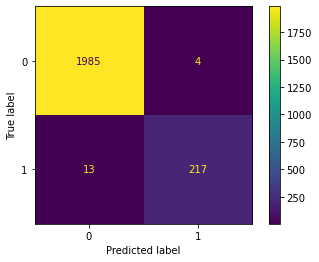

In [14]:
score_matrix_printer(baseline, X_train, y_train, X_test, y_test)

In [15]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline
from imblearn.pipeline import Pipeline as imbpipline

In [16]:
model_1 = imbpipline(steps=[
    ("preprocessor", preprocessor),
    ('SMOTE', SMOTE(random_state = 32)),
    ("classifier", LogisticRegression(max_iter = 1000, random_state=32))
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=32)

model_1.fit(X_train, y_train)
print("model score: %.3f" % model_1.score(X_test, y_test))

model score: 0.988



    Train Accuracy: 98.96%
    Train Precision: 91.51%
    ------------------------------
    Test Accuracy: 98.83%
    Test Precision: 90.16%
    


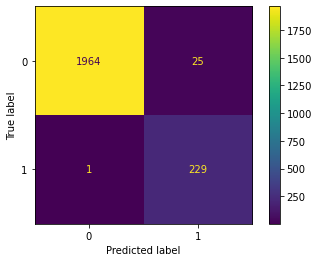

In [17]:
score_matrix_printer(model_1, X_train, y_train, X_test, y_test)